In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai_timeseries import *

ROCKET is a new time series classification method that achieves state-of-the-art performance with much faster speed than existing methods. It works by randomly generating a large number (default 20k) of features. Those features can then be used with any classifier.

[ROCKET paper by Dempster, Petitjean, and Webb](https://arxiv.org/pdf/1910.13051.pdf)

[Python implementation by Ignacio Oguiza](https://github.com/timeseriesAI/timeseriesAI)

A natural question to ask is, of those 20k features, is the model using all of them somewhat equally, or is it relying on a relatively small number of "good" features?

## Basic implementation of ROCKET

For the sake of simplicity, I used a dataset from the UCR archive with only two classes.

In [3]:
# loading data
X_train, y_train, X_valid, y_valid = get_UCR_data('Computers')
seq_len = X_train.shape[-1]
X_train = X_train[:, 0].astype(np.float64)
X_valid = X_valid[:, 0].astype(np.float64)
X_train.shape, X_valid.shape

((250, 720), (250, 720))

In [4]:
# normalize
X_train = (X_train - X_train.mean(axis = 1, keepdims = True)) / (X_train.std(axis = 1, keepdims = True) + 1e-8)
X_valid = (X_valid - X_valid.mean(axis = 1, keepdims = True)) / (X_valid.std(axis = 1, keepdims = True) + 1e-8)
X_train.mean(axis = 1, keepdims = True).shape

(250, 1)

For my model of choice, I used logistic regression because it's easy to see how much the model is using each feature.

In [5]:
# apply the model
kernels = generate_kernels(seq_len, 10000)
X_train_tfm = apply_kernels(X_train, kernels)
X_valid_tfm = apply_kernels(X_valid, kernels)
from sklearn.linear_model import LogisticRegression
model = sklearn.linear_model.LogisticRegression()
model.fit(X_train_tfm, y_train)
model.score(X_valid_tfm, y_valid)

0.624

## Feature Selection

Let's have a look at the learned weights.

In [6]:
w = (model.coef_).flatten()
w.shape

(20000,)

(-0.05, 0.05)

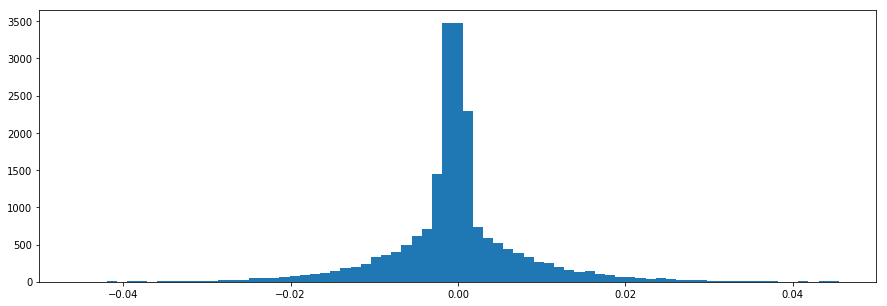

In [7]:
plt.figure(figsize=(15,5))
plt.hist(w, bins=100)
plt.xlim([-.05,.05])

It looks like most values are very close to 0, with just a few larger values. This suggests the model is relying mostly on just a few features. Let's filter for features with a magnitude greater than 0.01

In [8]:
ixs = np.abs(w) > 0.01
ixs.sum()

3284

In [9]:
X_train_small = X_train_tfm[:, ixs]
X_valid_small = X_valid_tfm[:, ixs]
X_train_small.shape, X_valid_small.shape

((250, 3284), (250, 3284))

In [10]:
model = sklearn.linear_model.LogisticRegression()
model.fit(X_train_small, y_train)
model.score(X_valid_small, y_valid)

0.628

Interesting! It appears it's able to get nearly the same accuracy with less than 20% of the features.

What if we went even farther and tried to select just a handful of the best features?

In [11]:
ixs = np.argpartition(np.abs(w), -10)[-10:] # select the 10 biggest features
ixs

array([ 6363,  6589,  3915, 14209,  7049, 14367, 18367,  9359, 17121, 17451])

In [12]:
w[ixs]

array([-0.051365, -0.05146 , -0.052487,  0.052149,  0.05235 , -0.053535, -0.055356,  0.066172,  0.062442,  0.054786])

In [13]:
X_train_small = X_train_tfm[:, ixs]
X_valid_small = X_valid_tfm[:, ixs]
X_train_small.shape, X_valid_small.shape

((250, 10), (250, 10))

In [14]:
model = sklearn.linear_model.LogisticRegression()
model.fit(X_train_small, y_train)
model.score(X_valid_small, y_valid)

0.588

In my experiments the results of going down to just 10 features were highly variable: sometimes it continued to perform well, other times the accuracy continued to make a big hit. Perhaps that's overkill. Let's automate the process of trying different numbers of features.

In [15]:
n = 1000 # number of features to keep

ixs = np.argpartition(np.abs(w), -n)[-n:] # get the features with the biggest weights

X_train_small = X_train_tfm[:, ixs]
X_valid_small = X_valid_tfm[:, ixs]

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train_small, y_train)
model.score(X_valid_small, y_valid)

0.652

While results are somewhat variable depending on the dataset and trial, I found you can usually get comparable or sometimes even better results with a small fraction of the features.

## What's the point?

While ROCKET is much faster than other methods with comparable accuracy, it can bog down with very large datasets. Feature selection is a promising way to speed up performance even more. Of course, you'll still have to train a model on all the features initially, but once you've isolated the key features, inference is really easy.

Qualitatively, this gives us a way to dig into what ROCKET is actually doing. An interesting next step would be to examine the kernels that produce the features with the highest weights. Can we identify kernels that pick up on classic time series features like trend and seasonality, similar to how a 2d convolution can be an "edge detector"?